In [ ]:
!pip install sweetviz

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sys
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
#import sweetviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Train.csv', parse_dates = ['InvoiceDate'])
test = pd.read_csv('/content/drive/My Drive/Test.csv', parse_dates = ['InvoiceDate'])

In [ ]:
df.drop_duplicates(inplace = True)
df['Quantity'] = abs(df['Quantity'])
df = df[(df['Quantity'] < 10000) & (np.abs(stats.zscore(df['UnitPrice'])) < 3) & (df['UnitPrice'] > 0)]

In [ ]:
#my_report = sweetviz.compare([df.drop(['InvoiceDate'],axis=1), "Train"], [test.drop(['InvoiceDate'],axis=1), "Test"], "UnitPrice")
#my_report.show_html("Report.html")

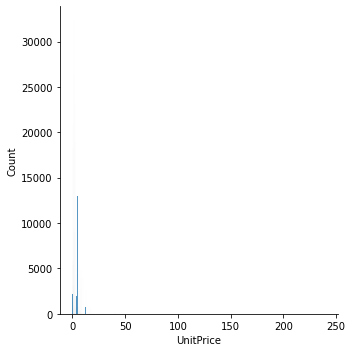

In [ ]:
sns.displot(df['UnitPrice'])

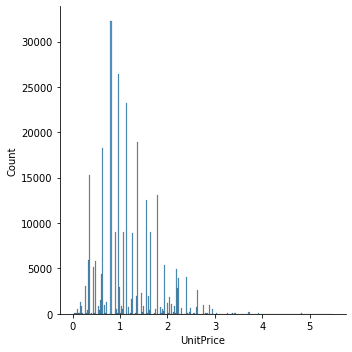

In [ ]:
df['UnitPrice'] = np.log1p(df['UnitPrice'])
sns.displot(df['UnitPrice'])

In [ ]:
df.describe()
df.nunique()

InvoiceNo      20894
StockCode       3618
Description     3817
Quantity         267
InvoiceDate    19392
UnitPrice        454
CustomerID      4332
Country           37
dtype: int64

In [ ]:
# Extracting Date features 
def date_features(df):
    #df['year'] = df['InvoiceDate'].dt.year
    df['month'] = df['InvoiceDate'].dt.month
    df['dayofweek'] = df['InvoiceDate'].dt.dayofweek
    df['day'] = df['InvoiceDate'].dt.day
    #df['dayofyear'] = df['InvoiceDate'].dt.dayofyear
    #df['week'] = df['InvoiceDate'].dt.week 
    #df['quarter'] = df['InvoiceDate'].dt.quarter  
    #df['Is_month_start'] = df['InvoiceDate'].dt.is_month_start 
    #df['Is_month_end'] = df['InvoiceDate'].dt.is_month_end
    #df['Is_quarter_start'] = df['InvoiceDate'].dt.is_quarter_start
    #df['Is_quarter_end'] = df['InvoiceDate'].dt.is_quarter_end 
    #df['Is_year_start'] = df['InvoiceDate'].dt.is_year_start 
    #df['Is_year_end'] = df['InvoiceDate'].dt.is_year_end 
    #df['daysinmonth'] = df['InvoiceDate'].dt.days_in_month 
    #df['isweekday'] = np.where(df['dayofweek'].isin([0,1,2,3,4]),1,0) 
    return df

In [ ]:
train = date_features(df)
test = date_features(test)

In [ ]:
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,dayofweek,day
0,6141,1583,144,3,2011-05-06 16:54:00,1.558145,14056.0,35,5,4,6
1,6349,1300,3682,6,2011-05-11 07:35:00,1.081805,13098.0,35,5,2,11
2,16783,2178,1939,4,2011-11-20 13:20:00,1.938742,15044.0,35,11,6,20
3,16971,2115,2983,1,2011-11-22 12:07:00,0.604316,15525.0,35,11,1,22
4,6080,1210,2886,12,2011-05-06 09:00:00,0.974560,13952.0,35,5,4,6


In [ ]:
def add_feature(df):
  df['Quantity'] = abs(df['Quantity'])
  df['unique_stock_per_invoice'] = df.groupby(['InvoiceNo'])['StockCode'].transform('nunique')
  #df['unique_desc_per_invoice'] = df.groupby(['InvoiceNo'])['Description'].transform('nunique')
  df['unique_stock_per_customer'] = df.groupby(['CustomerID'])['StockCode'].transform('nunique')
  #df['unique_desc_per_customer'] = df.groupby(['CustomerID'])['Description'].transform('nunique')
  #df['unique_desc_per_incust'] = df.groupby(['CustomerID', 'InvoiceNo'])['Description'].transform('nunique')
  df['unique_desc_per_stock'] = df.groupby(['StockCode'])['Description'].transform('nunique')
  df['quant_mean_per_desc'] = df.groupby(['StockCode', 'Description'])['Quantity'].transform('mean')
  #df['quant_min_per_desc'] = df.groupby(['StockCode', 'Description'])['Quantity'].transform('min')
  #df['quant_max_per_desc'] = df.groupby(['StockCode', 'Description'])['Quantity'].transform('max')
  df['quant_median_per_desc'] = df.groupby(['StockCode', 'Description'])['Quantity'].transform('median')
  #df['quant_std_per_custdesc'] = df.groupby(['CustomerID', 'Description'])['Quantity'].transform('std')
  df['quant_mean_per_dadesc'] = df.groupby(['Description','day'])['Quantity'].transform('mean')
  #df['quant_min_per_daydesc'] = df.groupby(['Description','day'])['Quantity'].transform('min')
  #df['quant_max_per_daydesc'] = df.groupby(['Description','day'])['Quantity'].transform('max')
  df['quant_median_per_daydesc'] = df.groupby(['Description','day'])['Quantity'].transform('median')
  #df['quant_std_per_daydesc'] = df.groupby(['Description','day'])['Quantity'].

  
  

In [ ]:
total = pd.concat([train,test], 0)
add_feature(total)

In [ ]:
train_f = total[:train.shape[0]]
test_f = total[train.shape[0]:]

In [ ]:
#train_f.info()
#test_f.info()
train_f.columns
test_f.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'month', 'dayofweek', 'day',
       'unique_stock_per_invoice', 'unique_stock_per_customer',
       'unique_desc_per_stock', 'quant_mean_per_desc', 'quant_median_per_desc',
       'quant_mean_per_daydesc', 'quant_median_per_daydesc'],
      dtype='object')

In [ ]:
X = train_f.drop(columns = ['InvoiceNo', 'Country', 'InvoiceDate', 'UnitPrice'])
y = train_f[['UnitPrice']]
test_f = test_f.drop(columns = ['InvoiceNo', 'Country', 'InvoiceDate', 'UnitPrice'])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## XGboost


In [ ]:
from xgboost import XGBRegressor

In [ ]:
model_1 = XGBRegressor(learning_rate = 0.2, n_estimators = 1000, max_depth = -1, subsample = 0.7, seed=1, eval_metric='rmse')
model_1.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=100)

[09:57:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.891311
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:0.418362
[200]	validation_0-rmse:0.271722
[300]	validation_0-rmse:0.230039
[400]	validation_0-rmse:0.212182
[500]	validation_0-rmse:0.202576
[600]	validation_0-rmse:0.195976
[700]	validation_0-rmse:0.189351
[800]	validation_0-rmse:0.183538
[900]	validation_0-rmse:0.178707
[999]	validation_0-rmse:0.174034


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.01,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1, silent=None, subsample=0.7, verbosity=1)

In [ ]:
xgb = XGBRegressor(learning_rate = 0.01, n_estimators = 1000, max_depth = 9, subsample = 0.7, seed=1, n_jobs = -1)
xgb_model = xgb.fit(X, y)


[16:24:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb_model.save_model('xgb.h5')

In [1]:
#pd.DataFrame(list(zip(X.columns, xgb_model.feature_importances_*100)))

In [ ]:
#score=cross_val_score(X=X,y=y,estimator=xgb,scoring='neg_root_mean_squared_error',cv=5)

[06:20:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#np.mean(score)

-0.26945987219247886

In [ ]:
y_pred1 = xgb.predict(test_f)
y_pred1 = np.expm1(y_pred1)

In [ ]:
y_pred1

array([2.042927 , 1.275885 , 3.5320377, ..., 1.1416446, 3.018926 ,
       3.8963878], dtype=float32)

## LGBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgb_params = {
 'min_data_in_leaf': [100, 500],
 'learning_rate': [0.01, 0.1, 0.2],
 'max_depth': [6, 9, 10, 15],
 'num_leaves': [31, 63]}

In [ ]:
lgb = LGBMRegressor(n_estimators = 1000, metric = 'rmse',
                    lambda_l1 = 0.01, lambda_l2 = 0.01, objective = 'regression', boosting_type = 'gbdt', random_state=1, n_jobs=-1)
#lgb.fit(X_train, y_train, eval_metric = 'rmse', eval_set = [(X_test, y_test)], early_stopping_rounds = 50)
randlgb = RandomizedSearchCV(lgb, param_distributions= lgb_params, n_iter = 5, cv = 5)

In [ ]:
randlgb.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           lambda_l1=0.01, lambda_l2=0.01,
                                           learning_rate=0.1, max_depth=-1,
                                           metric='rmse', min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0,
                                           n_estimators=1000, n_jobs=-1,
                                           num_leaves=31,
                                           objective='regression'...
                                           reg_lambda=0.0, silent=True,
                                           subsample=1.0,
       

In [ ]:
best_lgb = randlgb.best_estimator_
best_lgb.fit(X, y, verbose = 50)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l1=0.01, lambda_l2=0.01,
              learning_rate=0.1, max_depth=10, metric='rmse',
              min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=100, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_leaves=31, objective='regression', random_state=1,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#lgb = LGBMRegressor(n_estimators = int(lgb.best_iteration_*1.2), **lgb_params, random_state=1, n_jobs=-1)
#lgb_model = lgb.fit(X, y, verbose = 50)

In [2]:
#pd.DataFrame(list(zip(X.columns, best_lgb.feature_importances_)))

In [ ]:
#score = cross_val_score(X = X,y = y,estimator = lgb, scoring = 'neg_root_mean_squared_error',cv = 3, n_jobs = -1)

In [ ]:
#score

array([-0.19360348, -0.1913521 , -0.19775473])

In [ ]:

y_pred2 = best_lgb.predict(test_f)
y_pred2 = np.expm1(y_pred2)

In [ ]:
y_pred2

array([1.66912755, 1.13043442, 3.48106435, ..., 1.20408345, 3.46839563,
       3.86421358])

## Catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.3MB 50kB/s 


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
cat = CatBoostRegressor(task_type = 'GPU', iterations = 1500, learning_rate = 0.2, depth = 16, loss_function= 'RMSE', random_seed=1, verbose=100)
cat.fit(X, y)


0:	learn: 0.5250330	total: 191ms	remaining: 4m 45s
100:	learn: 0.1709511	total: 9.22s	remaining: 2m 7s
200:	learn: 0.1348894	total: 18.5s	remaining: 1m 59s
300:	learn: 0.1161809	total: 27.6s	remaining: 1m 50s
400:	learn: 0.1084467	total: 36.8s	remaining: 1m 40s
500:	learn: 0.1001312	total: 45.9s	remaining: 1m 31s
600:	learn: 0.0952008	total: 55.1s	remaining: 1m 22s
700:	learn: 0.0879194	total: 1m 4s	remaining: 1m 13s
800:	learn: 0.0854606	total: 1m 13s	remaining: 1m 3s
900:	learn: 0.0844510	total: 1m 22s	remaining: 54.6s
1000:	learn: 0.0832716	total: 1m 31s	remaining: 45.5s
1100:	learn: 0.0821188	total: 1m 40s	remaining: 36.5s
1200:	learn: 0.0809254	total: 1m 50s	remaining: 27.5s
1300:	learn: 0.0796358	total: 2m	remaining: 18.4s
1400:	learn: 0.0783250	total: 2m 11s	remaining: 9.32s
1499:	learn: 0.0781931	total: 2m 21s	remaining: 0us


In [ ]:
cat.save_model('cat.h5')

In [ ]:
pd.DataFrame(list(zip(X.columns, cat.feature_importances_))).sort_values(1)

,0,1
9,unique_desc_per_stock,1.441263
6,day,2.205275
5,dayofweek,2.260717
8,unique_stock_per_customer,2.333067
2,Quantity,2.542811
3,CustomerID,2.579680
12,quant_mean_per_daydesc,2.799533
4,month,3.387829
7,unique_stock_per_invoice,3.965145
13,quant_median_per_daydesc,6.338798


In [ ]:
#score = cross_val_score(X=X, y=y, estimator=cat, scoring='neg_root_mean_squared_error', cv=3)

In [ ]:
#score

array([-0.24877585, -0.25008026, -0.25125497])

In [ ]:

y_pred3 = cat.predict(test_f)
y_pred3 = np.expm1(y_pred3)

In [ ]:
y_pred3

array([1.57406184, 1.61833709, 3.36628232, ..., 0.9738654 , 3.55943291,
       3.81688161])

In [ ]:
y_pred = (y_pred*0.1) + (y_pred2*0.8) + (y_pred3*0.1)


In [ ]:
y_pred

array([1.6600948 , 1.18842915, 3.47191715, ..., 1.17880347, 3.48312577,
       3.8633561 ])

In [ ]:
output = pd.DataFrame({'UnitPrice' : np.abs(np.squeeze(y_pred))})
output.to_csv('submission.csv', index = False)